# Energy-based Model (In-progress)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**
- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/07_ebm/01_ebm/ebm.ipynb)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import math
import random
import collections
from typing import Any
from IPython import display
from tqdm.notebook import tqdm
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets

from functools import partial

import jax
from jax import numpy as jnp
from flax import struct
import flax.linen as nn
from flax.training import train_state

import optax
from clu import metrics

from matplotlib import pyplot as plt

## 0. Training Parameter

In [2]:
IMG_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 5e-3
ALPHA = 0.1
GRADIENT_CLIP = 3e-2
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 1e-4
EPOCHS = 60

# kwargs for model's tabulate function
console_kwargs = {"width": 100, 
                  "force_terminal": False, 
                  "force_jupyter": True,
                  "soft_wrap": True}

## 1. Preparing MNIST Dataset

In [3]:
def preprocess(imgs):
    imgs = (imgs.astype("float32") - 127.5) / 127.5 # map the image to [-1.0, 1.0]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values = -1.0)
    imgs = np.expand_dims(imgs, axis=-1)
    return imgs

def get_dataset():
    (train_ds, _), (test_ds, _) = datasets.mnist.load_data()
    train_ds = preprocess(train_ds)
    test_ds = preprocess(test_ds)

    train_ds = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(1024).batch(BATCH_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices(test_ds).batch(BATCH_SIZE)

    return train_ds, test_ds

In [4]:
sample_ds, _ = get_dataset()
sample_batch = next(sample_ds.as_numpy_iterator())
print(sample_batch.shape)

(128, 32, 32, 1)


## 2. Build Energy Function $E(x)$

In [5]:
class Energy(nn.Module):

    num_conv_layers:int = 4
    # Flax module does not accept mutable parameters
    channels:tuple = tuple([16, 32, 64, 64])
    kernels:tuple = tuple([5, 3, 3, 3])

    def setup(self):
        layers = []
        for i in range(self.num_conv_layers):
            layers.append(nn.Conv(features=self.channels[i],
                                  kernel_size=(self.kernels[i], self.kernels[i]),
                                  strides=2,
                                  padding="same"))
            layers.append(nn.activation.swish)
        
        self.conv_layers = nn.Sequential(layers)
        self.liner_layers = nn.Sequential([nn.Dense(64),
                                           nn.activation.swish,
                                           nn.Dense(1)])
        
    def __call__(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        return self.liner_layers(x)

In [6]:
print(Energy().tabulate(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 1)), console_kwargs=console_kwargs))

                                           Energy Summary                                           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path                ┃ module     ┃ inputs             ┃ outputs             ┃ params             ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│                     │ Energy     │ float32[1,32,32,1] │ float32[1,1]        │                    │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ conv_layers         │ Sequential │ float32[1,32,32,1] │ float32[1,2,2,64]   │                    │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ conv_layers/layers… │ Conv       │ float32[1,32,32,1] │ float32[1,16,16,16] │ bias: float32[16]  │
│                     │            │                    │                     │ kernel:            │
│                     │            │                    │                     │ float32[5,5,1,16]  │
│                     │            │                    │                     │                    │
│                     │            │                    │                     │ 416 (1.7 KB)       │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ conv_layers/layers… │ Conv       │ float32[1,16,16,1… │ float32[1,8,8,32]   │ bias: float32[32]  │
│                     │            │                    │                     │ kernel:            │
│                     │            │                    │                     │ float32[3,3,16,32] │
│                     │            │                    │                     │                    │
│                     │            │                    │                     │ 4,640 (18.6 KB)    │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ conv_layers/layers… │ Conv       │ float32[1,8,8,32]  │ float32[1,4,4,64]   │ bias: float32[64]  │
│                     │            │                    │                     │ kernel:            │
│                     │            │                    │                     │ float32[3,3,32,64] │
│                     │            │                    │                     │                    │
│                     │            │                    │                     │ 18,496 (74.0 KB)   │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ conv_layers/layers… │ Conv       │ float32[1,4,4,64]  │ float32[1,2,2,64]   │ bias: float32[64]  │
│                     │            │                    │                     │ kernel:            │
│                     │            │                    │                     │ float32[3,3,64,64] │
│                     │            │                    │                     │                    │
│                     │            │                    │                     │ 36,928 (147.7 KB)  │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ liner_layers        │ Sequential │ float32[1,256]     │ float32[1,1]        │                    │
├─────────────────────┼────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ liner_layers/layer… │ Dense      │ float32[1,256]     │ float32[1,64]       │ bias: float32[64]  │
│                     │            │                    │                     │ kernel:            │
│                     │            │                    │                     │ float32[256,64]    │
│                     │            │                    │                     │                    │
│                     │            │                    │                     │ 16,448 (65.8 KB)   │
├─────────────────────┼────────────┼────────────────────┼────

## 3. Setting Up Langevin Sampler

In [7]:
@jax.jit
def take_step(state, input_imgs, rng):
    
    @jax.grad
    def grad_fn(input_imgs):
        return state.apply_fn({"params": state.params},
                              input_imgs).sum()
        
    # step 1, add noise to the input image
    key, rng = jax.random.split(rng, 2)
    noise = jax.random.normal(key, shape=input_imgs.shape) * NOISE
    input_imgs += noise

    # step 2, get gradients for the current input
    grads = grad_fn(input_imgs)
    grads = jnp.clip(grads, a_min=-GRADIENT_CLIP, a_max=GRADIENT_CLIP)

    # step 3, apply gradients to the current input
    input_imgs += STEP_SIZE * grads + noise
    return input_imgs, rng
    

def generate_samples(state, rng, input_imgs, steps, step_size, return_img_per_step=False):
    if return_img_per_step:
        imgs_per_step = []
    
    for _ in range(steps):
        input_imgs, rng = take_step(state, input_imgs, rng)
        if return_img_per_step:
            imgs_per_step.append(np.array(input_imgs))

    if return_img_per_step:
        return np.stack(imgs_per_step, axis=0)
    else:
        return input_imgs

## 4. Setting up Buffer to Store Examples

In [8]:
class Buffer:

    sample_size:int = BATCH_SIZE
    channels:int = CHANNELS
    img_size:int = IMG_SIZE
    buffer_size:int = BUFFER_SIZE
    rng:Any = jax.random.PRNGKey(0)

    def __init__(self):
        self.examples = []
        for _ in range(self.sample_size):
            self.examples.append(
                np.random.uniform(low=-1.0, high=1.0, size=(1, self.img_size, self.img_size, self.channels))
            )
        self.generate_samples = generate_samples
    
    def sample_new_exmps(self, state, steps, step_size):
        key, self.rng = jax.random.split(self.rng, 2)
        # 95% samples from self.examples
        n_new = np.random.binomial(self.sample_size, 0.05)
        old_imgs = np.concatenate(random.choices(self.examples, k=self.sample_size-n_new), axis=0)
        # 5% samples from random noise
        rand_imgs = np.random.uniform(low=-1.0, 
                                      high=1.0, 
                                      size=(n_new, self.img_size, self.img_size, self.channels))
        input_imgs = np.concatenate([rand_imgs, old_imgs], axis=0)

        input_imgs = self.generate_samples(state, key, input_imgs, steps, step_size)
        input_imgs = np.array(input_imgs)
        self.examples = list(np.split(input_imgs,
                                      indices_or_sections=self.sample_size,
                                      axis=0)) + self.examples
        self.examples = self.examples[:self.buffer_size]
        return input_imgs

## 5. Setting up EBM `TrainState`

In [9]:
@struct.dataclass
class TrainMetrics(metrics.Collection):
    loss: metrics.Average.from_output("loss")
    cdiv_loss: metrics.Average.from_output("cdiv_loss")
    reg_loss: metrics.Average.from_output("reg_loss")
    real: metrics.Average.from_output("real")
    fake: metrics.Average.from_output("fake")

@struct.dataclass
class ValidMetrics(metrics.Collection):
    cdiv_loss: metrics.Average.from_output("cdiv_loss")
    real: metrics.Average.from_output("real")
    fake: metrics.Average.from_output("fake")


# EBM state class inherits flax's TrainState class
class EBM_state(train_state.TrainState):
    train_metrics: TrainMetrics
    valid_metrics: ValidMetrics


def create_ebm_state(model, params_key, lr=LEARNING_RATE):
    params = model.init(params_key, jnp.ones((1, IMG_SIZE, IMG_SIZE, CHANNELS)))["params"]
    tx = optax.adamw(learning_rate=lr)
    
    return EBM_state.create(
                apply_fn = model.apply,
                params=params,
                tx=tx,
                train_metrics=TrainMetrics.empty(),
                valid_metrics=ValidMetrics.empty())

## 6. Functions for Training, Validation, and Image Generation

- Train

In [10]:
@jax.jit
def emb_forward(state, input_imgs):
    # loss function
    def loss_fn(params, state):
        output = state.apply_fn({"params":params}, input_imgs)
        real_out, fake_out = jnp.split(output, indices_or_sections=2)
        
        reg_loss = ALPHA * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss
        
        metrics_updates = state.train_metrics.single_from_model_output(
                                reg_loss = reg_loss,
                                cdiv_loss = cdiv_loss,
                                loss = loss,
                                real = real_out.mean(),
                                fake = fake_out.mean())

        train_metrics = state.train_metrics.merge(metrics_updates)
        state = state.replace(train_metrics=train_metrics)
        return loss, state

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, state), grads = grad_fn(state.params, state)
    
    state = state.apply_gradients(grads=grads)
    return state


# train a single batch
def train_step(batch, state):
    real_imgs = batch.copy()
    noise = np.random.normal(size=real_imgs.shape) * NOISE
    real_imgs += noise
    real_imgs = real_imgs.clip(min=-1.0, max=1.0)
    fake_imgs = buffer.sample_new_exmps(state, STEPS, STEP_SIZE)
    input_imgs = np.concatenate([real_imgs, fake_imgs], axis=0)

    state = emb_forward(state, input_imgs)
    del real_imgs, fake_imgs, input_imgs

    return state

- Validation

In [11]:
def validate(batch, test_state):
    real_imgs = batch
    fake_imgs = np.random.uniform(low=-1.0, high=1.0, size=real_imgs.shape)
    input_imgs = np.concatenate([real_imgs, fake_imgs], axis=0)
    output = test_state.apply_fn({"params": test_state.params}, input_imgs)
    real_out, fake_out = np.split(output, indices_or_sections=2)
    cdiv_loss = fake_out.mean() - real_out.mean()

    metrics_updates = test_state.valid_metrics.single_from_model_output(
                        cdiv_loss=cdiv_loss,
                        real = real_out.mean(),
                        fake = fake_out.mean())
    valid_metrics = test_state.valid_metrics.merge(metrics_updates)
    test_state = test_state.replace(valid_metrics=valid_metrics)
    return test_state

- Generate

In [12]:
def show_generative_process(state, rng, num_samples=1):
    start_imgs = np.random.uniform(low=-1.0, 
                                   high=1.0, 
                                   size=(num_samples, IMG_SIZE, IMG_SIZE, CHANNELS))
    new_imgs = generate_samples(state, rng, start_imgs, 1000, STEP_SIZE, True)
    new_imgs = np.array(new_imgs)
    sequence = (0, 1, 3, 5, 10, 30, 50, 100, 300, 999)

    for j in range(num_samples):
        plt.figure(figsize=(16, 3))
        for i in range(len(sequence)):
            ax = plt.subplot(1, len(sequence), i+1)
            img = np.clip(new_imgs[sequence[i], j], a_min=-1.0, a_max=1.0)
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            ax.set_title(sequence[i])
        plt.show()


def generate_digits(state, rng, num_samples, imgs_per_row):
    start_imgs = np.random.uniform(low=-1.0, 
                                   high=1.0, 
                                   size=(num_samples, IMG_SIZE, IMG_SIZE, CHANNELS))
    new_imgs = generate_samples(state, rng, start_imgs, 1000, STEP_SIZE)
    new_imgs = np.array(new_imgs)

    n_rows = math.ceil(num_samples / imgs_per_row)
    
    # plt.figure(figsize=(16, 3))
    for i in range(len(new_imgs)):
        ax = plt.subplot(n_rows, imgs_per_row, i+1)
        img = np.clip(new_imgs[i], a_min=-1.0, a_max=1.0)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

## 7. Train EBM

In [13]:
energy_model = Energy()
buffer = Buffer()
rng = jax.random.PRNGKey(0)
ebm_state = create_ebm_state(energy_model, rng)
train_ds, test_ds = get_dataset()

# for metrics
train_batch_num = int(train_ds.cardinality())
test_batch_num = int(test_ds.cardinality())
train_history = collections.defaultdict(list)
valid_history = collections.defaultdict(list)

Epoch:  60


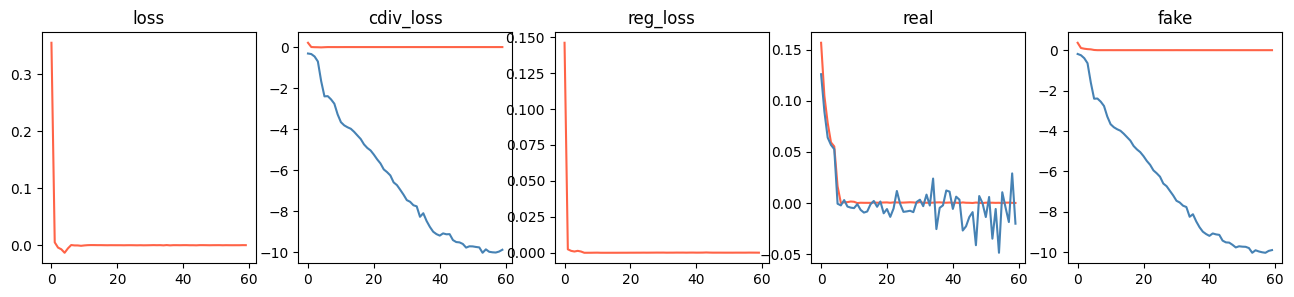

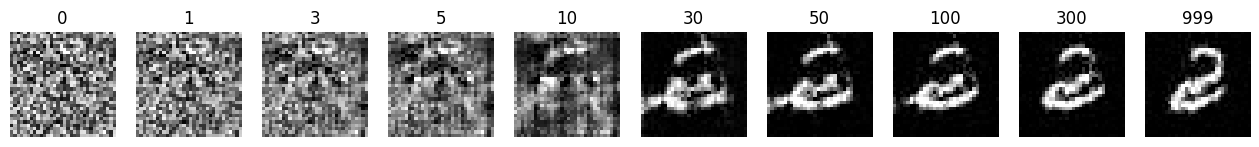

In [14]:
for epoch in range(EPOCHS):

    # training
    for batch in tqdm(train_ds.as_numpy_iterator(), total=train_batch_num):
        ebm_state = train_step(batch, ebm_state)

    # validation
    test_state = ebm_state
    for batch in tqdm(test_ds.as_numpy_iterator(), total=test_batch_num):
        test_state = validate(batch, test_state)

    print("\nEpoch: ", epoch + 1)
    for metric, value in ebm_state.train_metrics.compute().items():
        train_history[metric].append(value)
    for metric, value in test_state.valid_metrics.compute().items():
        valid_history[metric].append(value)

    ebm_state = ebm_state.replace(train_metrics=ebm_state.train_metrics.empty(),
                                  valid_metrics=ebm_state.valid_metrics.empty())

    # visualization
    display.clear_output(wait=True)
    
    print("Epoch: ", epoch + 1)
    # visualize metrics
    plt.figure(figsize=(16, 3))
    for i, key in enumerate(train_history):
        ax = plt.subplot(1, len(train_history), i + 1)
        ax.plot(train_history[key], c="tomato")
        if key in valid_history:
            ax.plot(valid_history[key], c="steelblue")
        ax.set_title(key)
    plt.show()
    
    show_generative_process(ebm_state, rng, 1)

## 8. Generate New Digits

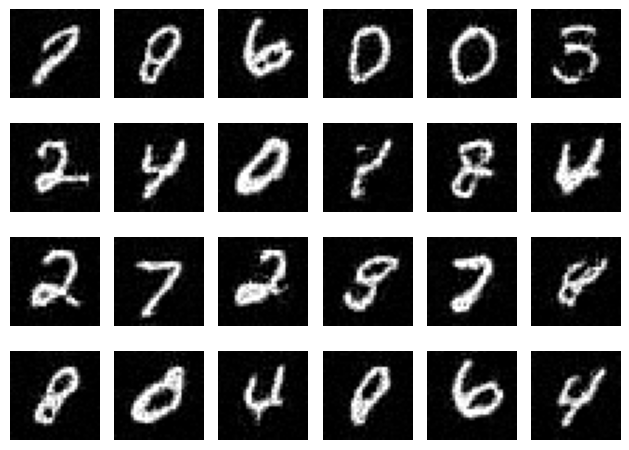

In [15]:
generate_digits(ebm_state, rng, 24, 6)